# Cifar10 上的 ReNet18

本文主要介绍在 cifar10 的试验 resnet18 的性能。

导入一些必要包：

In [1]:
import torch
from torch import nn, fx, optim
from torch.profiler import profile, record_function, ProfilerActivity
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.data.simple_vision import load_data_cifar10
from torch_book.tools import train, try_all_gpus, evaluate_accuracy
torch.cuda.empty_cache() # 清空 GPU 缓存

{mod}`torchvision` 上的 ResNet18 直接用于 cifar10 是不推荐的。需要做以下改动：

```{note}
将 `conv1` 替换以支持 $32 \times 32$ 的输入。同时移除第一个 `maxpool` 避免图片信息过早丢失。
```

In [2]:
def init_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                            model.conv1.out_channels,
                            3, 1, 1)
    model.maxpool = nn.Identity() # nn.Conv2d(64, 64, 1, 1, 1)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

In [3]:
model = init_model()

加载数据集：

In [4]:
batch_size = 64
train_iter, test_iter = load_data_cifar10(batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


打印每层输出尺寸：

In [5]:
for xs, _ in train_iter:
    break

for name, m in model.named_children():
    xs = m(xs)
    print(name, tuple(xs.shape))
    if name=="avgpool":
        xs = torch.flatten(xs, 1)

conv1 (64, 64, 32, 32)
bn1 (64, 64, 32, 32)
relu (64, 64, 32, 32)
maxpool (64, 64, 32, 32)
layer1 (64, 64, 32, 32)
layer2 (64, 128, 16, 16)
layer3 (64, 256, 8, 8)
layer4 (64, 512, 4, 4)
avgpool (64, 512, 1, 1)
fc (64, 10)


评估此时验证集的精度（由于替换了卷积运算，会造成大量精度损失）：

In [6]:
relu_acc = evaluate_accuracy(model, test_iter)
relu_acc

0.0855

微调模型：

In [7]:
def fine_tune(model, num_epochs,
              train_iter, test_iter,
              devices=try_all_gpus(),
              lr=0.0000142857,
              lr_period=4,
              lr_decay=0.0857142,
              weight_decay=0.00857142,
              momentum=0.857142):
    optimizer = optim.SGD(model.parameters(),
                          lr=lr,
                          momentum=momentum, 
                          weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                          step_size=lr_period, 
                                          gamma=lr_decay)
    train(model, train_iter, test_iter,
          num_epochs, devices,
          optimizer, scheduler)
    return model

train loss 0.003, train acc 0.999, valid acc 0.942
1638.6 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


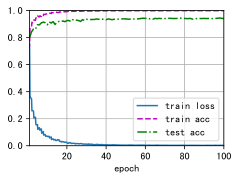

In [8]:
mod = fine_tune(model, 100,
                train_iter, test_iter, 
                try_all_gpus(),
                lr=0.000142857,
                lr_period=4,
                lr_decay=0.857142,
                weight_decay=0.00857142,
                momentum=0.857142)

保存模型：

In [9]:
torch.save(mod.state_dict(), 
           'models/resnet18_cifar10_relu.h5')

## 性能度量

In [10]:
inputs = torch.randn(5, 3, 32, 32).type(torch.float32).cuda()
        
with profile(activities=[ProfilerActivity.CPU, 
                         ProfilerActivity.CUDA], 
             record_shapes=True) as prof:
    with record_function("model_inference"):
        mod(inputs)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        20.30%       2.422ms        99.21%      11.839ms      11.839ms       0.000us         0.00%       2.220ms       2.220ms             1  
                                           aten::conv2d         0.62%      74.000us        55.28%       6.596ms     329.800us       0.000us         0.00%       2.040ms     102.000us            20  
         